In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model, Sequential
from skimage.transform import resize  # For resizing the heatmap

# Path to dataset
balanced_dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'

# Model parameters
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 2
epochs = 10  # Adjust as needed

# Data generators for training and validation (without augmentation)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    balanced_dataset_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    balanced_dataset_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Create the CNN model using Functional API for more flexibility
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='last_conv_layer')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Evaluate the model on the test set (same directory, no split)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    balanced_dataset_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Function to generate Grad-CAM heatmap with a circle marking the affected area
def plot_heatmap_with_circle(model, image_path, last_conv_layer_name='last_conv_layer'):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0  # Scale image between 0 and 1

    # Get model's prediction and predicted class
    preds = model.predict(x)
    predicted_class = np.argmax(preds[0])

    # Create the Grad-CAM model
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute gradients of the predicted class with respect to the last conv layer output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, predicted_class]

    # Calculate gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the pooled gradient values to create the heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize the heatmap

    # Resize the heatmap to match the original image
    heatmap_resized = resize(heatmap.numpy(), (img.size[1], img.size[0]))

    # Find the maximum activation point in the heatmap
    max_index = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)
    max_y, max_x = max_index

    # Plot the original image with Grad-CAM overlay and the circle
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)
    ax.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    ax.set_title(f'Grad-CAM with Circle\nPredicted Class: {predicted_class}')
    ax.axis('off')

    # Draw a circle around the maximum activation point
    circle_radius = 20  # Adjust radius as needed
    circle = plt.Circle((max_x, max_y), circle_radius, color='white', fill=False, linewidth=2)
    ax.add_patch(circle)

    plt.show()

# Example usage of Grad-CAM with a circle marking
image_path = '/kaggle/input/breakhis-400x/Breakhis-400x/benign/SOB_B_A-14-22549AB-400-001.png'
plot_heatmap_with_circle(model, image_path)


Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.4710 - loss: 1.0533 - val_accuracy: 0.5778 - val_loss: 0.8204
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.6615 - loss: 0.7675 - val_accuracy: 0.7016 - val_loss: 0.7317
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.7360 - loss: 0.6065 - val_accuracy: 0.7302 - val_loss: 0.6777
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.7716 - loss: 0.5111 - val_accuracy: 0.7175 - val_loss: 0.7878
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8250 - loss: 0.3982 - val_accuracy: 0.7333 - val_loss: 0.8967
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.8412 - loss: 0.3857 - val_accuracy: 0.7143 - val_loss: 1.1637
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.8771 - loss: 0.2930 - val_accuracy: 0.7714 - val_loss: 1.0531
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.9103 - loss: 0.2642 - val_accuracy: 0.669

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [5]:
# Check the model summary to find the correct layer name
model.save("DNBCD_Model.h5")

# Result Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


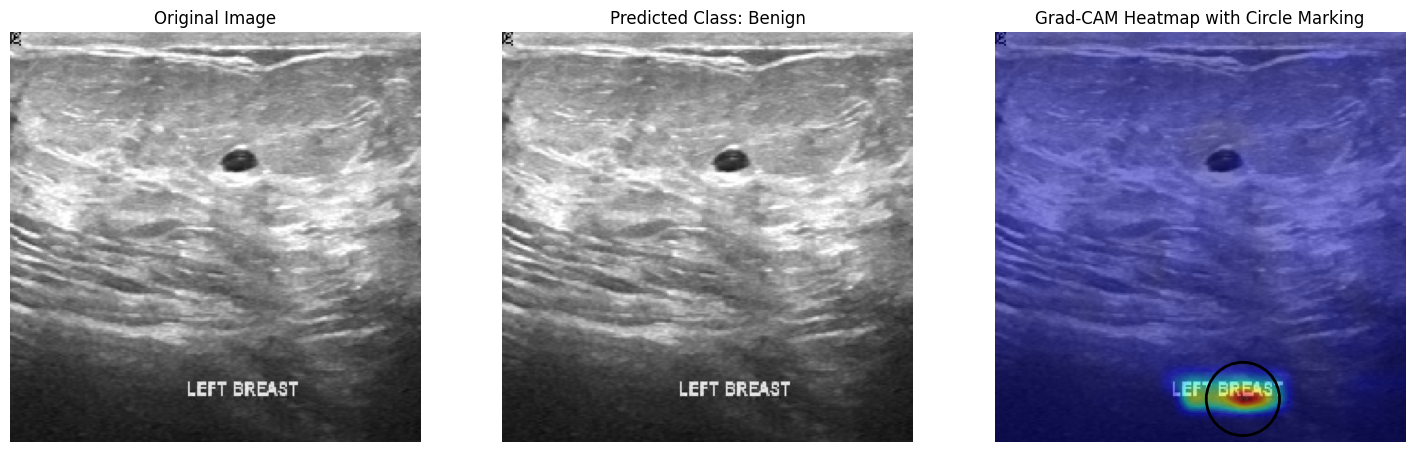

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize  # For resizing the heatmap
from scipy.ndimage import gaussian_filter  # For heatmap smoothing

# Load the saved model
model_path = '/kaggle/working/DNBCD_Model.h5'  # Path to your saved model
model = load_model(model_path)

# Function to generate Grad-CAM heatmap with subplots
def plot_heatmap_with_subplots(model, image_path, last_conv_layer_name='last_conv_layer'):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0  # Scale image between 0 and 1

    # Get the model's prediction and determine the predicted class
    preds = model.predict(x)
    predicted_class = np.argmax(preds[0])

    # Map predicted class to label
    if predicted_class == 0:
        label = "Benign"
    elif predicted_class == 1:
        label = "Malignant"
    else:
        label = "Normal"

    # Create the Grad-CAM model
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, predicted_class]

    # Compute the gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the pooled gradient values to generate the heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize the heatmap

    # Resize the heatmap to match the original image size
    heatmap_resized = resize(heatmap, (img.size[1], img.size[0]))

    # Apply Gaussian smoothing to the heatmap
    heatmap_smoothed = gaussian_filter(heatmap_resized, sigma=2)

    # Find the maximum activation point in the heatmap
    max_index = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)
    max_y, max_x = max_index

    # Create subplots
    fig = plt.figure(figsize=(18, 6))

    # Subplot 1: Original image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Subplot 2: Original image with predicted class label
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(img)
    ax2.set_title(f'Predicted Class: {label}')
    ax2.axis('off')

    # Subplot 3: Smoothed Grad-CAM heatmap with circle marking
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(img)
    ax3.imshow(heatmap_smoothed, cmap='jet', alpha=0.5)
    ax3.set_title('Grad-CAM Heatmap with Circle Marking')
    ax3.axis('off')

    # Draw a circle around the maximum activation point on the Grad-CAM heatmap
    circle_radius = 20  # Adjust the radius as needed
    circle = plt.Circle((max_x, max_y), circle_radius, color='black', fill=False, linewidth=2)
    ax3.add_patch(circle)
    plt.savefig("Result_Prediction.png", dpi=600, bbox_inches='tight')
    plt.show()

# Example usage of Grad-CAM with subplots
image_path = '/kaggle/input/d/sabahesaraki/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
plot_heatmap_with_subplots(model, image_path)

In [ ]:
image_path = '/kaggle/input/d/sabahesaraki/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (1).png'
plot_heatmap_with_subplots(model, image_path)

In [ ]:
image_path = '/kaggle/input/d/sabahesaraki/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (1).png'
plot_heatmap_with_subplots(model, image_path)